In [1]:
%%html
<script>
(function() {
  // Create the toggle button
  const rtlButton = document.createElement("button");
  rtlButton.textContent = "Toggle LTR";
  rtlButton.id = "top-rtl-toggle";
  rtlButton.style.marginLeft = "8px";
  rtlButton.style.padding = "4px 10px";
  rtlButton.style.fontSize = "14px";
  rtlButton.style.cursor = "pointer";

  // State
  var rtlActive = false;

  // Styling function
  var applyStyleToEditor = (editor) => {
    if (!editor) return;
    var direction = getComputedStyle(editor).getPropertyValue('direction')=='rtl' ? 'ltr' : 'rtl';
    var text_align = getComputedStyle(editor).getPropertyValue('text-align')=='right' ? 'left' : 'right';
    editor.style.setProperty('direction', direction, 'important');
    editor.style.setProperty('text-align', text_align, 'important');
  };

  // Toggle logic
  rtlButton.onclick = () => {
    rtlActive = !rtlActive;
    rtlButton.textContent = rtlActive ? "Toggle LTR" : "Toggle RTL";
    document.querySelectorAll('.jp-MarkdownCell .jp-InputArea-editor').forEach(applyStyleToEditor);
    document.querySelectorAll('.jp-RenderedHTMLCommon code, .jp-RenderedHTMLCommon code span').forEach(applyStyleToEditor);
    document.querySelectorAll('jp-RenderedHTMLCommon, .jp-RenderedHTMLCommon *').forEach(applyStyleToEditor);
  };

  // Watch for focus into editing Markdown cells
  // document.addEventListener('focusin', (event) => {
  //   const editor = event.target.closest('.jp-MarkdownCell .jp-InputArea-editor');
  //    if (editor) applyStyleToEditor(editor);
  // });

  // Insert into top toolbar if not already present
  var insertIntoToolbar = () => {
    const toolbar = document.querySelector('.jp-NotebookPanel-toolbar');
    if (toolbar && !document.getElementById("top-rtl-toggle")) {
      toolbar.appendChild(rtlButton);
    } else {
      // Try again in a moment if toolbar isn't ready yet
      setTimeout(insertIntoToolbar, 300);
    }
  };

  insertIntoToolbar();
})();
</script>

In [2]:
%%html
<!-- <style>
  table {display: inline-block}
</style> -->

# שבוע 9 - Numpy מתקדם

שבוע זה ממשיך את הבסיס ממחברת NumPy הקודמת, ומעמיק בנושאים שימושיים לפיסיקה חישובית:
- פעולות מטריציוניות: @, np.matmul, np.dot, transpose, ו-np.linalg.solve.
- ערכים/וקטורים עצמיים: np.linalg.eig, np.linalg.eigvals, קשרים ל-trace ול-det; אינטואיציה פיסיקלית.
- SVD: np.linalg.svd ורעיון דחיסה/פירוק מצבים.
- דוגמאות מסכמות: דחיסת תמונה והערכת מונטה-קרלו של π.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Modern RNG (prefer over legacy np.random.*)
rng = np.random.default_rng(seed=42)

np.__version__, "RNG OK"

('2.3.1', 'RNG OK')

## פעולות מטריציוניות
### @ ו-np.matmul
האופרטור @ שקול ל-np.matmul עבור מכפלות מטריציות. שניהם תומכים בבאצ'ינג (batch/broadcast) במימדים גבוהים.
שימו לב כי גם האופרטור וגם הפונקציה **לא** מבצעים כפל איבר-איבר; לשם כך משתמשים ב-*.

### np.dot
עבור שני וקטורים – מחזיר מכפלה סקלרית.
עבור מטריצות דו-ממדיות – שקול למכפלת מטריצות.
במימדים גבוהים הכללים שונים מעט (כפל לאורך הצירים האחרונים) ולכן נעדיף @/matmul לקוד ברור.

![Alt text](figs/0N7TO.png)



נדגים עבור שתי מטריצות ממימד 2:

In [4]:
A = np.array([[2., 1.],
              [0., 3.]])
B = np.array([[1., -1.],
              [4.,  2.]])

AB1 = A @ B            # matrix product via @
AB2 = np.matmul(A, B)  # same
AB3 = np.dot(A, B)     # same for 2D
print("AB1:")
print(AB1)
print("AB2:")
print(AB2)
print("AB3:")
print(AB3)


AB1:
[[ 6.  0.]
 [12.  6.]]
AB2:
[[ 6.  0.]
 [12.  6.]]
AB3:
[[ 6.  0.]
 [12.  6.]]


In [5]:
import json
from jupyterquiz import display_quiz

example = \
'''
[{
  "question": "נתונות המטריצות:<br><br>A = np.array([[1,2],[3,4]])<br><br>B = np.array([[5,6],[7,8]])<br><br>מה ההבדל בין np.dot(A,B) לבין np.matmul(A,B)?",
  "type": "many_choice",
  "answers": [
    {
      "answer": "אין הבדל: שתיהן מחזירות את [[19,22],[43,50]]",
      "correct": true,
      "feedback": "נכון! עבור מטריצות דו־ממדיות np.dot ו־np.matmul זהות"
    },
    {
      "answer": "np.dot מבצע מכפלה איבר־לאיבר ו־np.matmul מכפלה מטריציונית",
      "correct": false,
      "feedback": "לא נכון — מכפלה איבר־לאיבר נעשית עם * ולא עם dot"
    },
    {
      "answer": "np.dot מחזיר סקלר ו־np.matmul מחזיר מטריצה",
      "correct": false,
      "feedback": "זה נכון רק כשעובדים עם וקטורים חד־ממדיים, לא עם מטריצות 2D"
    },
    {
      "answer": "np.matmul עובד רק על מטריצות ריבועיות ואילו np.dot לא",
      "correct": false,
      "feedback": "לא נכון — np.matmul עובד גם על מטריצות מלבניות כל עוד הממדים תואמים"
    }
  ]
}]
'''
myquiz = json.loads(example)
display_quiz(myquiz)


<IPython.core.display.Javascript object>

### transpose / .T
טרנספוז של מטריצה 2D מחליף שורות בעמודות.
![Alt text](https://datascienceparichay.com/wp-content/uploads/2021/07/transpose-a-numpy-array.png)

In [6]:
A_T = A.T
B_T = B.T

AB1, AB2, np.allclose(AB1, AB2), np.allclose(AB1, AB3), A_T, B_T




(array([[ 6.,  0.],
        [12.,  6.]]),
 array([[ 6.,  0.],
        [12.,  6.]]),
 True,
 True,
 array([[2., 0.],
        [1., 3.]]),
 array([[ 1.,  4.],
        [-1.,  2.]]))

### Transpose למימדים גבוהים יותר
במערכים בעלי יותר משני ממדים (tensors), `transpose` מחליפה **סדר צירים** כללי.  
ברירת המחדל היא היפוך של סדר הצירים (axis reversal), אבל ניתן לשלוט בסדר הרצוי דרך ארגומנט `axes`.

- לדוגמה: מערך 3D מצורה `(time, x, y)`, לאחר  אם נעשה `np.transpose(A)`, יתקבל `(y, x, time)`.  
- שימושי במיוחד במעבר בין תיאורים שונים של נתונים (למשל, בין **row-major** ל-**column-major**, או סידור ערוצים בנתוני תמונה).

נמחיש זאת בדוגמא הבאה:

In [7]:
# 3D tensor of shape (2, 2, 3)
T = np.arange(12).reshape(2, 2, 3)

T_default = np.transpose(T)           # reverses axes -> shape (3, 2, 2)

T.shape, T_default.shape

((2, 2, 3), (3, 2, 2))

![Alt text](https://ajcr.net/images/stride-guide/3d_array_c_transpose.png)


כמו כן, ניתן לסמן צירים ולבחור את הסדר המתקבל:

In [8]:
# 3D tensor of shape (2, 3, 4)
T = np.arange(24).reshape(2, 3, 4)

T_default = np.transpose(T)           # reverses axes -> shape (4, 3, 2)
T_custom  = np.transpose(T, axes=(1, 0, 2))  # custom order -> shape (3, 2, 4)

T.shape, T_default.shape, T_custom.shape

((2, 3, 4), (4, 3, 2), (3, 2, 4))

In [9]:
import json
from jupyterquiz import display_quiz

example = \
'''
[{
  "question": "נתון מערך בגודל (2,3,4). מה תהיה הצורה החדשה אם נבצע <br><br>transpose(1,0,2)<br><br>עם סדר צירים ?",
  "type": "many_choice",
  "answers": [
    {
      "answer": "(3,2,4)",
      "correct": true,
      "feedback": "נכון! החלפנו בין הציר הראשון והשני, השלישי נשאר במקום"
    },
    {
      "answer": "(2,4,3)",
      "correct": false,
      "feedback": "לא נכון — זה היה קורה אם היינו מחליפים בין הציר השני לשלישי"
    },
    {
      "answer": "(4,3,2)",
      "correct": false,
      "feedback": "לא נכון — זה קורה אם עושים A.T כלומר היפוך כל הצירים"
    },
    {
      "answer": "(2,3,4)",
      "correct": false,
      "feedback": "לא נכון — זה היה מתקבל אם לא היינו משנים את סדר הצירים כלל"
    }
  ]
}]
'''
myquiz = json.loads(example)
display_quiz(myquiz)


<IPython.core.display.Javascript object>

### פעולות מטריציוניות עם Batch ו־Broadcasting

ב־NumPy ניתן לבצע מכפלות מטריציוניות לא רק בין מטריצות בודדות, אלא גם בין *אוספים* של מטריצות 
(batch) בצורה וקטורית.

נראה שתי דוגמאות:
1. **מכפלת מטריצה–וקטור עבור batch של מטריצות**:  
   כל מטריצה ב־batch מוכפלת באותו וקטור.
2. **מכפלת מטריצה–מטריצה עבור batch של מטריצות**:  
   כל זוג מטריצות תואם ב־batch מוכפל אחת בשנייה.

In [10]:
# Batched matrix-vector multiply: shape (batch, n, n) @ (n,)
batch = 5
M = rng.normal(size=(batch, 3, 3))
v = rng.normal(size=3)

# Broadcasting: each 3x3 in M multiplies the same vector v -> (batch, 3)
Mv = M @ v

במקרה זה התקבלה תוצאה במימדים `(batch, 3)`, כלומר 5 וקטורים שונים באורך 3 —
כל אחד תוצאה של כפל מטריצה מה־batch עם אותו וקטור $v$.

In [11]:
N = rng.normal(size=(batch, 3, 3))  # another batch of 5 random 3x3 matrices

# Batched matrix-matrix: (batch, n, n) @ (batch, n, n) -> (batch, n, n)
MM = M @ N
MM.shape

(5, 3, 3)

כאן התוצאה במימדים `(batch, 3, 3)` — כלומר 5 מטריצות חדשות, שכל אחת מהן תוצאה 
של כפל זוג המטריצות המתאים מתוך $M$ ו־$N$.

In [12]:
import json
from jupyterquiz import display_quiz

example = \
'''
[{
  "question": "נתון הקוד הבא:<br><br>\
A = np.ones((5, 3, 3))<br>\
v = np.ones(3)<br><br>\
מה תהיה הצורה של A @ v ?",
  "type": "many_choice",
  "answers": [
    {
      "answer": "הצורה (5,3)",
      "correct": true,
      "feedback": "נכון! כל אחת מ־5 המטריצות בגודל 3x3 מוכפלת באותו וקטור באורך 3"
    },
    {
      "answer": "הצורה (3,3)",
      "correct": false,
      "feedback": "לא נכון — זה היה נכון אילו A הייתה מטריצה אחת בלבד"
    },
    {
      "answer": "הצורה (5,3,3)",
      "correct": false,
      "feedback": "לא נכון — זו הייתה התוצאה אילו היינו עושים broadcasting עם כפל איבר־לאיבר"
    },
    {
      "answer": "הצורה (,5)",
      "correct": false,
      "feedback": "לא נכון — זה היה מתקבל אם כל מטריצה הייתה מוכפלת בסקלר"
    }
  ]
}]
'''
myquiz = json.loads(example)
display_quiz(myquiz)


<IPython.core.display.Javascript object>

## פתרון מערכות לינאריות

נניח שיש לנו מערכת של משוואות לינאריות (כלומר משוואות שבהן המשתנים מופיעים בחזקה ראשונה בלבד), לדוגמה:

$$
\begin{cases}
2x_1 + x_2 = 5 \\
x_1 - x_2 = 1
\end{cases}
$$

אפשר לכתוב זאת בצורה מטריציונית קומפקטית:

$$
A x = b
$$

ייצוג מפורש:

$$
A = \begin{bmatrix}
2 & 1 \\
1 & -1
\end{bmatrix},
\quad
x = \begin{bmatrix}
x_1 \\
x_2
\end{bmatrix},
\quad
b = \begin{bmatrix}
5 \\
1
\end{bmatrix}.
$$

כאשר:
* $A$ היא מטריצה שמכילה את המקדמים של המשוואות,
* $x$ הוא וקטור המשתנים הבלתי ידועים,
* $b$ הוא וקטור התוצאות (האגפים הימניים).

כך מקבלים את הכתיבה הקומפקטית:

$$
A x = b
\quad \Longleftrightarrow \quad
\begin{bmatrix}
2 & 1 \\
1 & -1
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}
=
\begin{bmatrix}
5 \\
1
\end{bmatrix}.
$$

### שתי דרכים לפתרון
1. לחשב במפורש את $A^{-1}$ (המטריצה ההפוכה של $A$), ואז להציב:

   $$
   x = A^{-1} b
   $$

2. להשתמש ישירות באלגוריתם נומרי שמחשב את $x$ בלי למצוא את $A^{-1}$:
```python
   x = np.linalg.solve(A, b)
```


```{note}
מדוע לא נחשב את $A^{-1}$ ישירות?
* **חוסר יציבות נומרית**: מחשב עובד עם ספרות מוגבלות (למשל 16 ספרות עשרוניות). 
  חישוב המטריצה ההפוכה עלול להגדיל שגיאות קטנות במספרים, במיוחד אם $A$ קרובה להיות לא הפיכה (סינגולרית).
* **יעילות**: לחשב מטריצה הפוכה זה ארוך ומיותר אם כל מה שאנחנו רוצים זה לפתור את המערכת. 
  `np.linalg.solve` משתמש בשיטות ישירות (כמו פירוק LU) שמגיעות לפתרון מהר יותר ובצורה מדויקת יותר.
```
`````{admonition} סיבוכיות (במה תלוים זמן ומשאבי החישוב)
:class: tip
* אם $A$ בגודל $n \times n$, חישוב $A^{-1}$ דורש בערך $\mathcal{O}(n^3)$ פעולות, 
  ואז צריך גם להכפיל אותה ב־$b$ שזה $\mathcal{O}(n^2)$ נוספות.
* לעומת זאת, `np.linalg.solve` פותר את המערכת ישירות עם $\mathcal{O}(n^3)$ פעולות, **בלי** לעשות את הצעד המיותר של חישוב $A^{-1}$.
`````

`````{admonition} דוגמאות פיסיקליות
:class: tip
מערכות לינאריות מופיעות כמעט בכל תחום בפיסיקה:

* **מעגלים חשמליים**: לפי חוקי אוהם וקירכהוף נוצרת מערכת משוואות לינאריות למציאת מתחים וזרמים.
* **מכניקה קלאסית**: מערכת של מסות מחוברות בקפיצים מתוארת על ידי משוואות לינאריות לכוחות ותזוזות.
* **אנליזת תגובה (response analysis)**: קביעה כיצד מערכת מגיבה לגירוי (לדוגמה שדה חשמלי או כוח חיצוני).
* **חישוב התפתחות בזמן קצר**: בצעד אינטגרציה נומרית של משוואות דיפרנציאליות נדרשת לעיתים קרובות הפתרה של מערכת לינארית בכל צעד.
`````

### מספר התניה (Condition Number)

לפעמים המערכת "רגישה" לשינויים קטנים.  
כדי למדוד זאת משתמשים ב־**מספר ההתניה** של $A$, שמוגדר כך:

$$
\kappa(A) = \|A\| \cdot \|A^{-1}\|
$$

אם $\kappa(A)$ קטן, המערכת יציבה — שגיאות קטנות בנתונים לא משפיעות הרבה על התוצאה.  
אם $\kappa(A)$ גדול, המערכת לא יציבה — טעות קטנה במדידות או בחישובים עלולה לגרום לשינוי גדול מאוד בפתרון.

ב־NumPy אפשר לחשב את זה בעזרת:
```python
np.linalg.cond(A)
``` 

```{note}
#### כלל אצבע
**אל תחשבו $A^{-1}$** אלא השתמשו ב-`np.linalg.solve`, ובדקו את ה-condition number אם אתם חושדים שמדובר במטריצה "כמעט סינגולרית".
```


### דוגמה: פתרון מערכת לינארית פשוטה

נגדיר מטריצה $A$ ווקטור אגף ימין $b$, שמייצגים מערכת של שתי משוואות בשני נעלמים.  
נשתמש ב־`np.linalg.solve` כדי למצוא את הפתרון $x$ שמקיים את $Ax = b$.  
בסוף נחשב את ה־residual (השארית) כלומר $Ax - b$, כדי לבדוק עד כמה הפתרון באמת מתאים — 
במערכת מדויקת השארית אמורה להיות קרובה מאוד ל־0.


In [13]:
# Solve Ax = b (single RHS)
A = np.array([[3., 1.],
              [1., 2.]])
b = np.array([9., 8.])

x = np.linalg.solve(A, b)
residual = A @ x - b
x, residual


(array([2., 3.]), array([0., 0.]))

### דוגמה: מערכת כמעט סינגולרית (Nearly Singular)

כאן נגדיר מטריצה $C$ שקרובה מאוד להיות סינגולרית (כלומר כמעט לא הפיכה).  
במקרים כאלה מספר ההתניה $\kappa(C)$ יוצא גדול מאוד, מה שמצביע על כך שהמערכת רגישה במיוחד לשינויים קטנים.  

נראה זאת בכך שנפתור את אותה מערכת פעמיים: פעם עם וקטור אגף ימין $d_1$, ופעם עם $d_2$ שנבדל ממנו רק בשינוי זעיר.  
נבחין כי הפתרונות $x_1$ ו־$x_2$ שונים בצורה משמעותית — עדות לכך שמערכות כאלה אינן יציבות נומרית, 
ואפילו טעות קטנה במדידות יכולה לשנות לגמרי את התוצאה.


In [14]:
# Nearly singular system: sensitive to perturbations
C = np.array([[1., 1.],
              [1., 1.000001]])
condC = np.linalg.cond(C)

d1 = np.array([2., 2.])
d2 = np.array([2., 2.000001])  # tiny perturbation

x1 = np.linalg.solve(C, d1)
x2 = np.linalg.solve(C, d2)

condC, x1, x2


(np.float64(4000002.0005977214), array([2., 0.]), array([1., 1.]))

### דוגמה: פתרון מערכת עם מספר אגפים בצד ימין

במקום לפתור את המערכת $Ax = b$ עבור וקטור אחד של אגף ימין,  
אפשר לפתור בבת אחת עבור כמה וקטורים שונים. במקרה זה נגדיר מטריצה $B$ שכל עמודה בה היא אגף ימין שונה.  

הפקודה `np.linalg.solve(A, B)` מחזירה מטריצה $X$, כאשר כל עמודה ב־$X$ היא פתרון מתאים ל־$Ax = b$ של העמודה המקבילה ב־$B$.  

כך ניתן לפתור כמה מערכות דומות במקביל ביעילות, במקום להריץ את הפתרון שוב ושוב עבור כל וקטור בנפרד.


In [15]:
# Multiple right-hand sides (Ax = B)
B = np.column_stack([b, [1., 0.]])  # matrix of RHS
X = np.linalg.solve(A, B)

print(B)
np.allclose(A @ X, B), X

[[9. 1.]
 [8. 0.]]


(True,
 array([[ 2. ,  0.4],
        [ 3. , -0.2]]))

In [16]:
import json
from jupyterquiz import display_quiz

example = \
'''
[{
  "question": "עבור פתרון מערכת עם מספר אגפים בצד ימין<br><br>A = np.array([[3., 1.],[1., 2.]])<br>b = np.array([9., 8.])<br>B = np.column_stack([b, [1., 0.]])<br>X = np.linalg.solve(A, B)<br><br>מה נכון לגבי X?",
  "type": "many_choice",
  "answers": [
    {
      "answer": "כל עמודה ב־X היא פתרון של Ax = b המתאים לעמודה ב־B",
      "correct": true,
      "feedback": "נכון! np.linalg.solve(A, B) פותר במקביל עבור כל עמודה של B"
    },
    {
      "answer": "A @ X שווה ל־B (עד סטיות חישוב קטנות)",
      "correct": true,
      "feedback": "נכון! זהו הקריטריון לבדיקה מהירה שהפתרון נכון"
    },
    {
      "answer": "צורת המטריצה X היא (2,)",
      "correct": false,
      "feedback": "לא נכון — X היא מטריצה בגודל (2, 2) כי יש שתי עמודות אגף ימין"
    },
    {
      "answer": "כדי לפתור עבור שתי העמודות חייבים לולאה על כל עמודה בנפרד",
      "correct": false,
      "feedback": "לא נכון — solve תומכת באופן וקטורי במטריצת אגפים ימניים"
    }
  ]
}]
'''
myquiz = json.loads(example)
display_quiz(myquiz)


<IPython.core.display.Javascript object>

### שיטת הריבועים הפחותים (Least Squares)

לא תמיד למערכת המשוואות $Ax = b$ יש פתרון מדויק:
- אם יש יותר משוואות מאשר נעלמים ($m > n$) — המערכת **עודפת**. בד"כ אין פתרון אחד שיכול לקיים את כולן בו־זמנית.
- אם יש פחות משוואות מאשר נעלמים ($m < n$) — המערכת **חסרה**. יש יותר מדי דרגות חופש, ולכן קיימים אינסוף פתרונות אפשריים.

במקרים כאלה ניתן להשתמש בשיטת **הריבועים הפחותים** (Least Squares). לשיטה זו שימושים רבים בפיסיקה
הרעיון הוא לא לדרוש פתרון מושלם, אלא למצוא את הווקטור $x$ שמקטין עד כמה שאפשר את ההפרש בין הפתרון המוצע לבין הנתונים. בכתיבה מתמטית:

$$
x^\ast = \arg \min_x \|Ax - b\|_2
$$

במילים פשוטות: אנחנו מחפשים פתרון $x$ שמביא לכך שהשגיאה הכוללת בין $Ax$ לבין $b$ (סכום ריבועי הסטיות) תהיה הכי קטנה שאפשר.  

```{note}
שימו לב לסימון $\|Ax - b\|_2$:
* הסימן $\|\cdot\|$ נקרא **נורמה** – מדד לאורך או "גודל" של וקטור.  
* תת־המספר $_2$ מציין שזו **נורמת 2** (או "נורמת אוקלידס"), כלומר האורך הרגיל של וקטור במרחב.  
  לדוגמה, אם $v = (v_1, v_2, \dots, v_n)$ אז:

  $$
  \|v\|_2 = \sqrt{v_1^2 + v_2^2 + \cdots + v_n^2}
  $$

* במקרה שלנו, $v = Ax - b$ הוא וקטור השגיאות (כמה רחוק הפתרון שלנו מהנתונים האמיתיים).  
כלומר $\|Ax - b\|_2$ הוא אורך וקטור השגיאות.  
```

ב־Least Squares אנחנו מחפשים את $x$ שמקטין את האורך הזה ככל האפשר, או בצורה אחרת:  
שמביא לכך שסכום ריבועי הסטיות יהיה הקטן ביותר.

זוהי דרך סטנדרטית להתאים קו ישר לנתונים ניסיוניים עם רעש, או באופן כללי להתאים מודל לינארי למדידות.


ב־NumPy אפשר להשתמש ב־`np.linalg.lstsq`:

```python
x, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
```

הפלט כולל:
- x – הפתרון שממזער את הטעות.
- residuals – סכום ריבועי השגיאות (יכול להיות ריק אם המערכת חסרה).
- rank – הדרגה של $A$ (כמה שורות "בלתי תלויות" יש במערכת).
- s – הערכים הסינגולריים של $A$ (קשור ליציבות החישוב).

דוגמאות שימוש נפוצות בפיסיקה והנדסה:

- התאמת נתונים (Data Fitting): התאמת קו ישר או פולינום לנקודות ניסוי.
- שחזורים חישוביים: כאשר המערכת חסרה (underdetermined), מחפשים פתרון מינימום-נורמה.
- אנליזת רעש: מציאת קירוב הטוב ביותר לנתונים כאשר $b$ מכיל רעש ניסוי.

### דוגמה: התאמת קו ישר בשיטת Least Squares

נניח שיש לנו סדרה של נתונים ניסיוניים, למשל נקודות שמייצגות מדידות פיזיקליות במעבדה.  
אנחנו מאמינים שהקשר בין המשתנים הוא בקירוב קו ישר:

$$
y \approx a + b x
$$

כאשר:
* $a$ הוא הקבוע החופשי (intercept) – ערך $y$ כאשר $x=0$.
* $b$ הוא השיפוע – כמה $y$ משתנה עבור שינוי של יחידה אחת ב־$x$.

### בעיה אמיתית: רעש במדידות
במדידות אמיתיות, הערכים של $y$ לא נמצאים בדיוק על קו ישר — תמיד יש רעש ושגיאות.  
לכן המטרה שלנו היא למצוא את הקו $\hat{y} = a^\ast + b^\ast x$ שהוא "הכי קרוב" לנתונים בפועל.  

בשיטת הריבועים הפחותים (least-squares) אנחנו בוחרים את $a^\ast, b^\ast$ כך שהם מקטינים את סכום ריבועי הסטיות של הנקודות מהקו:

$$
(a^\ast, b^\ast) = \arg \min_{a,b} \; \sum_{i=1}^N \big( y_i - (a + b x_i) \big)^2
$$

```{note}
פירוש האיברים:
* $x_i$ – ערך ה־x של נקודת המדידה ה־$i$.
* $y_i$ – ערך ה־y הנמדד של אותה נקודה (יכול לכלול רעש).
* $a + b x_i$ – הערך שחוזה הקו שלנו עבור $x_i$.
* $y_i - (a + b x_i)$ – ההפרש (שגיאה) בין המדידה לבין החיזוי של הקו.
* $\big( y_i - (a + b x_i) \big)^2$ – ריבוע השגיאה (כדי שכל הטעויות יהיו חיוביות ושגדולות ייספרו יותר).
* $\sum_{i=1}^N$ – סכום כל ריבועי השגיאות על פני כל $N$ הנקודות.
* $\arg \min_{a,b}$ – המשמעות היא: בחר את $a, b$ שגורמים לסכום הזה להיות הכי קטן שאפשר.
```

כלומר, הקו לא יעבור דרך כל הנקודות, אלא יהיה זה שמצמצם את השגיאה הכוללת בצורה הטובה ביותר.


### ניסוח מטריציוני
נוח לכתוב את הבעיה בצורה של מטריצות ווקטורים:

$$
\mathbf{y} \approx A \mathbf{c}
$$

כאשר:
* $A$ היא **מטריצת design** בגודל $N \times 2$, שבה כל שורה מייצגת נקודה אחת:

  $$
  A = 
  \begin{bmatrix}
  1 & x_1 \\
  1 & x_2 \\
  \vdots & \vdots \\
  1 & x_N
  \end{bmatrix}
  $$

* $\mathbf{c} = \begin{bmatrix} a \\ b \end{bmatrix}$ הוא וקטור הפרמטרים שאנחנו רוצים למצוא.
* $\mathbf{y}$ הוא וקטור התצפיות (כל הערכים שנמדדו בניסוי, כולל רעש).

#### הפתרון ב־NumPy
ניתן להשתמש בפונקציה:

```python
x, residuals, rank, s = np.linalg.lstsq(A, y, rcond=None)
```

היא מחזירה לנו את הפתרון $a^\ast, b^\ast$ שמגדירים את הקו המתאים ביותר לנתונים.
כך אפשר למצוא את השיפוע והחיתוך עם הציר גם כשהנתונים רועשים ולא יושבים בדיוק על קו ישר.


In [17]:
import json
from jupyterquiz import display_quiz

example = \
'''
[{
  "question": "בבעיית התאמת קו ישר לנתונים ניסיוניים עם רעש,<br><br>מה בעצם עושה שיטת הריבועים הפחותים (Least Squares)?",
  "type": "many_choice",
  "answers": [
    {
      "answer": "מוצאת את a ו-b כך שהקו עובר דרך כל הנקודות בדיוק",
      "correct": false,
      "feedback": "לא נכון — בגלל רעש אין קו אחד שעובר דרך כל הנקודות"
    },
    {
      "answer": "מוצאת את a ו-b שמקטינים את סכום ריבועי הסטיות בין הקו לבין הנתונים",
      "correct": true,
      "feedback": "נכון! השיטה מחפשת את הקו שהכי קרוב לנתונים בממוצע"
    },
    {
      "answer": "בוחרת את השיפוע b בלבד ומתעלמת מהקבוע a",
      "correct": false,
      "feedback": "לא נכון — הפתרון כולל גם את הקבוע וגם את השיפוע"
    },
    {
      "answer": "מתאימה את הקו רק לנקודה הראשונה והאחרונה",
      "correct": false,
      "feedback": "לא נכון — השיטה משתמשת בכל הנקודות בבת אחת"
    }
  ]
}]
'''
myquiz = json.loads(example)
display_quiz(myquiz)


<IPython.core.display.Javascript object>

### דוגמה: יצירת נתונים מלאכותיים ובדיקת התאמת קו ישר

כדי להדגים את שיטת הריבועים הפחותים ניצור נתונים מלאכותיים (synthetic data).  
נגדיר קו ישר "אמיתי" עם שיפוע $b = 2.0$ וחותך $a = 1.5$, ואז נוסיף לו רעש אקראי קטן המדמה טעויות במדידה.  
כך נקבל סדרה של נקודות $(x_i, y_i)$ שנראות כמו תוצאות ניסוי אמיתי.

לאחר מכן נבנה מטריצה $A$, ונשתמש ב־`np.linalg.lstsq` כדי למצוא את הקו $\hat{y} = a^\ast + b^\ast x$  
שמתאים בצורה הטובה ביותר לנתונים באמצעות שיטת least-squares.  
הפלט יכלול את מקדמי הקו המותאם ואת השאריות (residuals) שמודדות עד כמה הקו מתאים לנתונים.

In [18]:
# Synthetic data: y ≈ a + b x
xdata = np.linspace(0, 1, 50)
ytrue = 1.5 + 2.0*xdata
yobs  = ytrue + rng.normal(scale=0.1, size=xdata.size)  # noisy observations

# Design matrix for linear fit: [1, x]
A = np.column_stack([np.ones_like(xdata), xdata])

# Least-squares fit
coef, residuals, rank, s = np.linalg.lstsq(A, yobs, rcond=None)

coef, residuals

(array([1.44784207, 2.07187258]), array([0.52182849]))

### הצגת תוצאות ההתאמה הגרפית

כעת נשרטט את הנתונים ואת הקווים להשוואה:

* הנקודות הכחולות הן המדידות (כולל רעש ניסויי).
* הקו השחור המקווקו הוא הקו "האמיתי" שממנו יצרנו את הנתונים.
* הקו האדום הוא הקו שחישבנו באמצעות `np.linalg.lstsq` — קו ה־least-squares שמתאים בצורה הטובה ביותר לנקודות.

השוואה זו מאפשרת להמחיש עד כמה השיטה מצליחה לשחזר את הקו האמיתי גם כאשר הנתונים רועשים.

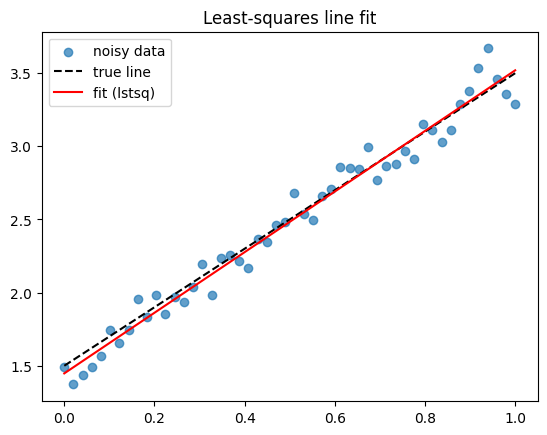

In [19]:
plt.scatter(xdata, yobs, label="noisy data", alpha=0.7)
plt.plot(xdata, ytrue, 'k--', label="true line")
plt.plot(xdata, A @ coef, 'r-', label="fit (lstsq)")
plt.legend()
plt.title("Least-squares line fit")
plt.show()

In [20]:
import json
from jupyterquiz import display_quiz

example = \
'''
[{
  "question": "נתונות שתי נקודות ניסוי: (x=0, y=1), (x=1, y=3).<br><br>מהו הקו y = a + b·x ששיטת Least Squares תחזיר?",
  "type": "many_choice",
  "answers": [
    {
      "answer": "y = 1 + 2x",
      "correct": true,
      "feedback": "נכון! שתי נקודות מגדירות קו יחיד שעובר דרכן, כאן החיתוך a=1 והשיפוע b=2"
    },
    {
      "answer": "y = 0 + 3x",
      "correct": false,
      "feedback": "לא נכון — קו זה עובר דרך (0,0) ולא מתאים לנקודות הנתונות"
    },
    {
      "answer": "y = 2 + 1x",
      "correct": false,
      "feedback": "לא נכון — קו זה עובר דרך (0,2), לא דרך (0,1)"
    },
    {
      "answer": "y = 1.5 + 1.5x",
      "correct": false,
      "feedback": "לא נכון — זהו קו אחר, לא הקו היחיד שעובר דרך שתי הנקודות הנתונות"
    }
  ]
}]
'''
myquiz = json.loads(example)
display_quiz(myquiz)


<IPython.core.display.Javascript object>

## ערכים עצמיים, וקטורים עצמיים, עקבה ודטרמיננטה

למטריצה $A$ מתקבלים **ערכים עצמיים** $\lambda_i$ ו־**וקטורים עצמיים** $v_i$ כך ש־

$$
A v_i = \lambda_i v_i .
$$

### אינטואיציה פיסיקלית
בפיסיקה, ערכים ווקטורים עצמיים מופיעים בהקשרים רבים:
- **מצבים נורמליים** במערכות לינאריות — למשל תנודות קטנות סביב נקודת שיווי משקל.
- **כיווני יציבות/אי־יציבות** במערכות דינמיות.
- **צירים עיקריים** של התפלגות או קירוב קוודרטי (principal axes).

* `np.linalg.eig(A)` מחזירה `(w, V)`:
  - `w` – מערך הערכים העצמיים.
  - `V` – מטריצה שבה כל עמודה היא וקטור עצמי מתאים.
* `np.linalg.eigvals(A)` מחזירה רק את הערכים העצמיים.

במקרה של מטריצה **סימטרית** (או הרמיטית ממשית), מתקיים:
* הערכים העצמיים ממשיים.
* הווקטורים העצמיים ניתנים לבחירה כאורתונורמליים (זווית ישרה ונורמה 1).
* לשימוש כזה עדיף `np.linalg.eigh`, המנצל את מבנה הסימטריה ומחזיר תוצאה יציבה יותר.

### קשרים שימושיים
* העקבה (trace) של מטריצה היא סכום הערכים העצמיים:

  $$
  \mathrm{trace}(A) = \sum_i \lambda_i
  $$

* הדטרמיננטה (det) היא מכפלת הערכים העצמיים:
  
  $$
  \det(A) = \prod_i \lambda_i
  $$

### ערכים עצמיים ווקטורים עצמיים עבור מטריצה סימטרית

כאשר $A$ היא מטריצה סימטרית (כלומר $A^T = A$), יש לה תכונות נוחות במיוחד:
* כל הערכים העצמיים שלה ממשיים.
* הווקטורים העצמיים שלה אורתונורמליים (מאונכים ובעלי אורך 1).

ב־NumPy עדיף להשתמש ב־`np.linalg.eigh` (במקום `eig`) עבור מטריצות כאלה, משום שהאלגוריתם מנצל את הסימטריה ומחזיר תוצאה יציבה וממוינת.

בדוגמה הזו נחשב:
* את הערכים העצמיים $w$ והווקטורים העצמיים $V$,
* את העקבה (`trace`) והדטרמיננטה (`det`) של $A$,
* ונראה שאכן מתקיים $\mathrm{trace}(A) = \sum_i \lambda_i$ ו־$\det(A) = \prod_i \lambda_i$.
  
בנוסף נבדוק:
* שהווקטורים העצמיים אורתונורמליים ($V^T V = I$),
* ושניתן לשחזר את $A$ מפירוק הערכים העצמיים:  
  $$
  A \approx V \, \mathrm{diag}(w) \, V^T
  $$



In [21]:
# Symmetric example: prefer eigh
A = np.array([[4., 1., 0.],
              [1., 3., 1.],
              [0., 1., 2.]], dtype=float)

w, V = np.linalg.eigh(A)     # sorted ascending
trA = np.trace(A)
detA = np.linalg.det(A)

trace_vs_sum = trA, np.sum(w)
det_vs_prod   = detA, np.prod(w)

# Check orthonormality and reconstruction A ≈ V diag(w) V^T
Icheck = V.T @ V
Arec = V @ np.diag(w) @ V.T
np.allclose(Icheck, np.eye(3)), np.allclose(Arec, A), trace_vs_sum, det_vs_prod


(True,
 True,
 (np.float64(9.0), np.float64(9.000000000000002)),
 (np.float64(17.999999999999996), np.float64(18.000000000000007)))

### מטריצה לא סימטרית וערכים עצמיים מרוכבים

לא כל המטריצות הן סימטריות. כאשר $A$ אינה סימטרית, ייתכן שהערכים העצמיים שלה יהיו **מספרים מרוכבים**.

בדוגמה הזו נגדיר מטריצה $B$ שמתארת סיבוב במישור:

$$
B = \begin{bmatrix}
0 & -1 \\
1 & \;\;0
\end{bmatrix}
$$

המטריצה הזו לא סימטרית, ולכן הערכים העצמיים שלה יוצאים מרוכבים:

$$
\lambda = \pm i
$$

ב־NumPy נשתמש ב־`np.linalg.eig` כדי לקבל גם את הערכים העצמיים (שיכולים להיות מרוכבים) וגם את הווקטורים העצמיים המתאימים.

In [22]:
# Non-symmetric example: complex eigenvalues are possible
B = np.array([[0., -1.],
              [1.,  0.]])
wB, VB = np.linalg.eig(B)
wB, VB


(array([0.+1.j, 0.-1.j]),
 array([[0.70710678+0.j        , 0.70710678-0.j        ],
        [0.        -0.70710678j, 0.        +0.70710678j]]))

## SVD – פירוק לערכים סינגולריים

פירוק לערכים סינגולריים (Singular Value Decomposition – SVD) הוא דרך לייצג כל מטריצה $A$ (אפילו אם היא לא ריבועית) כמכפלה של שלוש מטריצות:

$$
A = U \, \Sigma \, V^T
$$

כאשר:
* $U$ היא מטריצה אורתונורמלית בגודל $m \times m$ (וקטורים אורתונורמליים בשורות/עמודות).
* $V$ היא מטריצה אורתונורמלית בגודל $n \times n$.
* $\Sigma$ היא מטריצה מלבנית $m \times n$ שבתוכה ערכים ממשיים אי-שליליים, הנקראים **ערכים סינגולריים**:
  
  $$
  \Sigma = 
  \begin{bmatrix}
  \sigma_1 & 0 & 0 & \dots \\
  0 & \sigma_2 & 0 & \dots \\
  0 & 0 & \sigma_3 & \dots \\
  \vdots & \vdots & \vdots & \ddots
  \end{bmatrix}
  $$

  כאשר $\sigma_1 \geq \sigma_2 \geq \cdots \geq 0$.

`````{admonition} אינטואיציה
:class: tip
ה־SVD אומר בעצם שכל מטריצה $A$ אפשר לראות כסיבוב (באמצעות $V^T$), אחר כך **מתיחה בכיוונים מסוימים** (באמצעות הערכים $\sigma_i$ שב־$\Sigma$), ואז עוד סיבוב (באמצעות $U$).
`````

### שימושים עיקריים

1. **דחיסת מידע / הפחתת מימד**  
   הערכים הסינגולריים $\sigma_i$ ממוינים מהגדול לקטן.  
   אם נשמור רק את הגדולים ביותר ונזרוק את הקטנים, נקבל קירוב טוב של $A$ בעזרת הרבה פחות מידע.  
   לדוגמה: דחיסת תמונה ע"י שמירה על כמה עשרות ערכים סינגולריים ראשונים בלבד.

2. **ניתוח מצבים דומיננטיים**  
   בבעיות פיזיקליות ומדעיות, וקטורים עצמיים/סינגולריים מתארים "כיוונים עיקריים" של פעולה או תגובה של מערכת.  
   למשל: למצוא את הכיוון שבו אנרגיה או שונות הנתונים היא הגדולה ביותר.

3. **Least-Squares יציב נומרית**  
   כאשר פותרים מערכת עודפת $Ax \approx b$, אפשר להשתמש ב־SVD כדי למצוא פתרון יציב:

   $$
   x^\ast = V \, \Sigma^+ \, U^T b
   $$

   כאן $\Sigma^+$ היא המטריצה ההפוכה הפסבדו־מנורית (pseudoinverse) של $\Sigma$.  
   זהו כלי חשוב כאשר המערכת "כמעט סינגולרית" או רועשת.


### סיכום
* ה־SVD מפרק כל מטריצה לשלושה מרכיבים: $U$, $\Sigma$, $V^T$.  
* הערכים הסינגולריים $\sigma_i$ מספרים לנו כמה "חזקה" התרומה של כל כיוון.  
* השימושים מגוונים – מתורת המידע ודחיסת תמונות ועד לפתרון מערכות משוואות עם רעש או חוסר יציבות.


In [23]:
import json
from jupyterquiz import display_quiz

example = \
'''
[{
  "question": "ב־SVD של מטריצה A נכתוב A = U Σ Vᵀ. מה נכון?",
  "type": "many_choice",
  "answers": [
    {
      "answer": "Σ מכילה ערכים סינגולריים אי־שליליים וממוינים מהגדול לקטן",
      "correct": true,
      "feedback": "נכון! זהו לב ה-SVD"
    },
    {
      "answer": "U ו-V הן מטריצות אורתונורמליות",
      "correct": true,
      "feedback": "נכון — עמודותיהן מאונכות ובנורמה 1"
    },
    {
      "answer": "SVD פועל גם למטריצות מלבניות, לא רק ריבועיות",
      "correct": true,
      "feedback": "בדיוק — זה אחד היתרונות הגדולים של SVD"
    },
    {
      "answer": "Σ יכולה להכיל גם ערכים שליליים",
      "correct": false,
      "feedback": "לא נכון — הערכים הסינגולריים אינם שליליים"
    }
  ]
}]
'''
myquiz = json.loads(example)
display_quiz(myquiz)


<IPython.core.display.Javascript object>

## דוגמה מסכמת (1): פירוק SVD על תמונה (או על תמונה סינתטית)

בואו נראה איך אפשר להשתמש ב־SVD לדחיסת תמונה.  
דחיסה היא תהליך שבו אנחנו מצמצמים את כמות המידע הדרושה לייצוג של אובייקט (כמו תמונה, וידאו או קובץ טקסט), מבלי לאבד יותר מדי מהתוכן המקורי. הרעיון הוא להשתמש בפחות ביטים כדי לאחסן או לשדר את אותו המידע.
הרעיון: במקום לשמור את כל הפיקסלים של התמונה, נפרק את מטריצת התמונה ל־$U \Sigma V^T$,  
ונשמור רק את כמה הערכים הסינגולריים הגדולים ביותר.  

כך מקבלים קירוב טוב מאוד לתמונה המקורית, אבל עם הרבה פחות מידע.

### דחיסת תמונה סינתטית

נחשוב על תמונה כעל טבלה של מספרים בין 0 ל־1 (שחור–לבן).  
נבנה תמונה פשוטה: עיגול בהיר על רקע בהיר־קצת (גרדיאנט).  
נבצע פירוק $A = U \Sigma V^T$ ונשחזר את התמונה עם $k$ הערכים הסינגולריים הגדולים בלבד.

רעיון מרכזי:
- $\sigma_1, \sigma_2, \ldots$ (הערכים הסינגולריים) מסודרים מהגדול לקטן.
- שמירה רק על $k$ הגדולים נותנת קירוב טוב של התמונה, אבל עם פחות מידע (דחיסה).


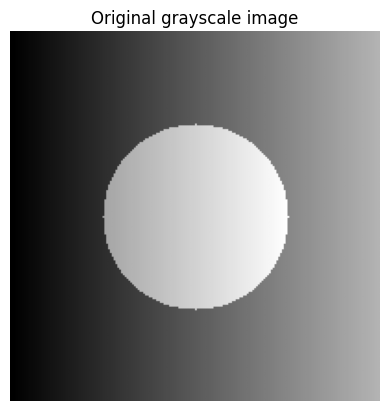

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Build a simple 2D grayscale "image" (no external libraries)
H, W = 200, 200
y, x = np.ogrid[:H, :W]

# Simple circle mask
radius = H // 4
circle = ((x - W//2)**2 + (y - H//2)**2) <= radius**2
circle = circle.astype(float)

# Horizontal gradient in [0,1]
grad = x / (W - 1)

# Mix: image = 0.6*gradient + 0.4*circle
img = 0.6 * grad + 0.4 * circle

# Show the original grayscale image
plt.figure()
plt.title("Original grayscale image")
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()


נבצע את ה־SVD של המטריצה (התמונה) ונראה את הממדים שהתקבלו ואת מספר הערכים הסינגולריים הראשונים.

In [25]:
# Compute SVD
U, s, Vt = np.linalg.svd(img, full_matrices=False)

print("Shapes:")
print("U:", U.shape, " s:", s.shape, " Vt:", Vt.shape)

# Print first few singular values (they are already 1D numbers)
print("First 5 singular values:", s[:5])


Shapes:
U: (200, 200)  s: (200,)  Vt: (200, 200)
First 5 singular values: [87.14902758 15.56242399  7.92470633  4.5784639   3.2616076 ]


פונקציית השחזור מבוססת על פירוק ה־SVD:

$$
A = U \cdot \Sigma \cdot V^T
$$

כאשר:
* $U$ – מטריצה שכל העמודות שלה אורתונורמליות (כל אחת היא כיוון בסיסי "חדש").
* $V^T$ – מטריצה אורתונורמלית אחרת שמייצגת כיוונים בצד השני.
* $\Sigma$ – מטריצה אלכסונית (רוב הערכים בה אפס), ועל האלכסון נמצאים הערכים הסינגולריים 
  $\sigma_1 \geq \sigma_2 \geq \dots \geq 0$.


#### קירוב בעזרת $k$ רכיבים בלבד
בפועל, רוב התרומה של המטריצה $A$ מגיעה מהערכים הסינגולריים הגדולים ביותר.  
לכן אפשר לכתוב קירוב:

$$
A_k = U_{(:,1:k)} \cdot \mathrm{diag}(\sigma_1,\dots,\sigma_k) \cdot V^T_{(1:k,:)}
$$

```{note}
נסביר:
* $U_{(:,1:k)}$ – לוקחים רק את $k$ העמודות הראשונות של $U$.
* $\mathrm{diag}(\sigma_1,\dots,\sigma_k)$ – שומרים רק את $k$ הערכים הסינגולריים הגדולים ביותר.
* $V^T_{(1:k,:)}$ – לוקחים את $k$ השורות הראשונות של $V^T$.
```

`````{admonition} אינטואיציה
:class: tip
אפשר לחשוב על זה כמו לבנות את המטריצה $A$ כ"סכום של שכבות" (layers):

$$
A = \sigma_1 u_1 v_1^T + \sigma_2 u_2 v_2^T + \cdots
$$

כאשר $u_i$ הוא העמודה ה־$i$ של $U$ ו־$v_i^T$ היא השורה ה־$i$ של $V^T$.

אם לוקחים רק את $k$ הראשונים:

$$
A_k = \sigma_1 u_1 v_1^T + \cdots + \sigma_k u_k v_k^T,
$$

אנחנו מקבלים קירוב פשוט יותר – פחות "שכבות" – אבל קרוב מאוד ל־$A$ אם הערכים שנזרקו היו קטנים.

:בהקשר של תמונה
* כאשר $k$ קטן (למשל $k=5$) – רואים את הצורה הכללית של התמונה אבל בלי פרטים.
* כאשר $k$ בינוני (למשל $k=20$) – התמונה כבר נראית די טובה.
* כאשר $k$ גדול (למשל $k=60$) – התמונה כמעט זהה למקור.
`````

כך ניתן לדחוס את המידע: לשמור הרבה פחות נתונים (רק $k$ ערכים וכמה וקטורים) ועדיין לשחזר תמונה קרובה מאוד למקור.


k=  5  relative error ≈ 0.0593


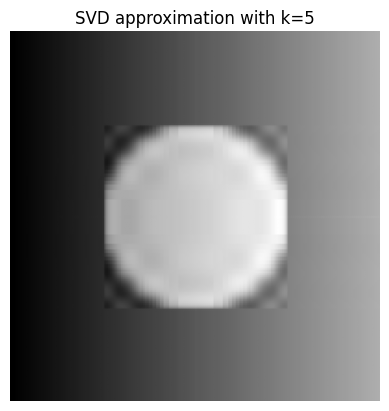

k= 20  relative error ≈ 0.0200


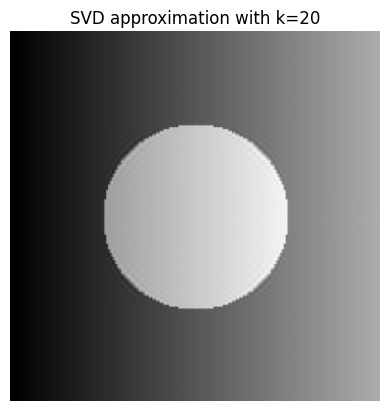

k= 60  relative error ≈ 0.0000


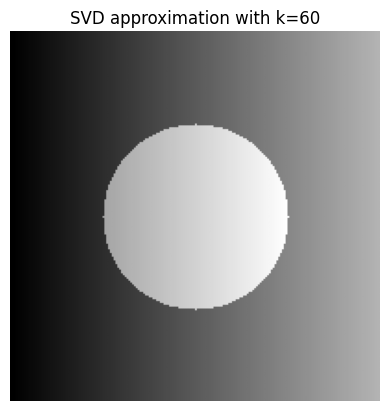

In [26]:
def svd_approx(U, s, Vt, k):
    # Reconstruct using the top-k singular values/vectors
    k = int(max(1, min(k, s.size)))  # clamp k to [1, rank]
    return (U[:, :k] * s[:k]) @ Vt[:k, :]

for k in [5, 20, 60]:
    approx = svd_approx(U, s, Vt, k)

    # Relative reconstruction error ||A - A_k|| / ||A||
    rel_err = np.linalg.norm(img - approx) / np.linalg.norm(img)
    print(f"k={k:>3}  relative error ≈ {rel_err:.4f}")

    plt.figure()
    plt.title(f"SVD approximation with k={k}")
    plt.imshow(approx, cmap="gray")
    plt.axis("off")
    plt.show()


### כמה אנרגיה נשמרה?

כדי למדוד עד כמה הקירוב $A_k$ שומר על המידע של המטריצה המקורית $A$, משתמשים ב**אנרגיה**.

ב־SVD, הערכים הסינגולריים $\sigma_i$ מודדים כמה חזקה התרומה של כל רכיב $i$ לתמונה או לנתונים.  
ככל שהערך $\sigma_i$ גדול יותר – הוא מייצג יותר מידע חשוב.

### מדד האנרגיה
נגדיר את סך כל האנרגיה של המטריצה כ־

$$
E_\text{total} = \sum_{i=1}^r \sigma_i^2
$$

כאשר $r = \min(m,n)$ הוא הדרגה המקסימלית האפשרית.

אם אנחנו שומרים רק את $k$ הערכים הסינגולריים הגדולים ביותר, אז האנרגיה שנשמרה היא:

$$
E(k) = \sum_{i=1}^k \sigma_i^2
$$

ולכן היחס (כלומר כמה אחוז מהמידע נשמר) הוא:

$$
\text{Ratio}(k) = \frac{E(k)}{E_\text{total}} = \frac{\sum_{i=1}^k \sigma_i^2}{\sum_{i=1}^r \sigma_i^2}
$$

`````{admonition} אינטואיציה
:class: tip
* אם $k$ קטן – נשמר רק אחוז קטן מהאנרגיה, כלומר התמונה משוחזרת חלקית בלבד.
* אם $k$ גדול – רוב האנרגיה נשמרת, והתמונה כמעט זהה למקור.
* לכן נוהגים לבחור $k$ כך שנשמר נניח **90%–95% מהאנרגיה**, מה שנותן איזון טוב בין איכות הקירוב לבין גודל הנתונים.
`````

במילים פשוטות: היחס $\text{Ratio}(k)$ אומר לנו כמה מה"תוכן החשוב" של המטריצה המקורית הצלחנו לשמור בקירוב שלנו.


k=  5  energy ≈  99.6%
k= 20  energy ≈ 100.0%
k= 60  energy ≈ 100.0%
k=100  energy ≈ 100.0%


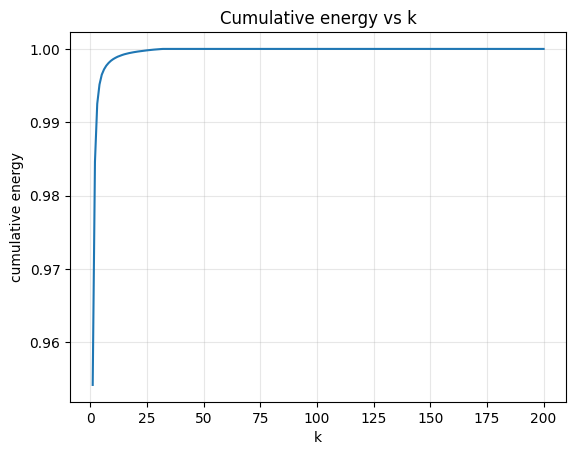

In [27]:
energy_cum = np.cumsum(s**2) / np.sum(s**2)
for k in [5, 20, 60, 100]:
    if k <= s.size:
        print(f"k={k:>3}  energy ≈ {energy_cum[k-1]*100:5.1f}%")

plt.figure()
plt.title("Cumulative energy vs k")
plt.plot(np.arange(1, s.size+1), energy_cum)
plt.xlabel("k")
plt.ylabel("cumulative energy")
plt.grid(True, alpha=0.3)
plt.show()


### סיכום: מדידת האנרגיה המצטברת

בתא הקוד אנחנו מחשבים את **האנרגיה המצטברת** שנשמרת ככל שמוסיפים יותר ערכים סינגולריים בקירוב:

1. `np.cumsum(s**2)` – מחשב את הסכום המצטבר של $\sigma_i^2$, כלומר כמה אנרגיה מצטברת עד ערך סינגולרי מסוים $k$.
2. מחלקים ב־`np.sum(s**2)` – כדי לקבל יחס בין 0 ל־1 (או בין 0% ל־100%).
3. עבור $k=5,20,60,100$ – מדפיסים כמה אחוז מהאנרגיה נשמר.
4. מציירים גרף שבו הציר האופקי הוא $k$ (כמה ערכים סינגולריים השתמשנו), והציר האנכי הוא האנרגיה המצטברת שנשמרה.

התוצאה: רואים שהאנרגיה עולה מהר מאוד בתחילת הגרף – כלומר רק מעט ערכים סינגולריים גדולים כבר מסבירים חלק גדול מהתמונה.  
זו הסיבה ש־SVD שימושי לדחיסה: אפשר לשמור אחוז קטן מהמידע ועדיין לשחזר כמעט את כל התוכן.


In [28]:
import json
from jupyterquiz import display_quiz

example = \
'''
[{
  "question": "נניח שיש לנו תמונה בגודל 200x200 ואחרי פירוק SVD קיבלנו 200 ערכים סינגולריים. אנחנו משחזרים את התמונה עם k=20 בלבד.<br><br>מה נכון לגבי הקירוב?",
  "type": "many_choice",
  "answers": [
    {
      "answer": "התמונה תשחזר את המבנה הכללי (צורה, בהירות כללית) אבל תאבד פרטים עדינים",
      "correct": true,
      "feedback": "נכון! הערכים הראשונים מכילים את רוב המידע הגס, אך לא את כל הפרטים"
    },
    {
      "answer": "כמות המידע שנשמרת קטנה בהרבה מאשר במטריצה המקורית",
      "correct": true,
      "feedback": "נכון! במקום לשמור 200x200 פיקסלים, שומרים רק את 20 הערכים הגדולים ועוד את הווקטורים המתאימים"
    },
    {
      "answer": "התמונה המשוחזרת תהיה זהה לתמונה המקורית",
      "correct": false,
      "feedback": "לא נכון — אם לא שומרים את כל 200 הערכים הסינגולריים יש תמיד אובדן מידע"
    },
    {
      "answer": "היחס בין האנרגיה שנשמרה לבין המקור תלוי ביחס בין סכום (σ_i בריבוע) עבור i=1..20 לבין סכום (σ_i בריבוע) לכל ה־200",
      "correct": true,
      "feedback": "נכון! האנרגיה שנשמרת נקבעת על פי הערכים הסינגולריים ששמרנו"
    }
  ]
}]
'''
myquiz = json.loads(example)
display_quiz(myquiz)


<IPython.core.display.Javascript object>

## דוגמה מסכמת (2): הערכת מונטה–קרלו של π
שיטת מונטה־קרלו היא משפחה של שיטות חישוב המבוססות על דגימה אקראית מרובה במטרה להעריך כמויות מתמטיות או פיזיקליות שקשה לחשב ישירות. במקום לפתור בעיה מורכבת בצורה אנליטית (כמו אינטגרל מסובך בממד גבוה), נבצע הרבה ניסויים אקראיים מבוקרים, נחשב את התוצאה בכל ניסוי, ונשתמש בממוצע של התוצאות כדי להתקרב לפתרון האמיתי.  

נשתמש בשיטה לחישוב $\pi$: נזרוק באקראי ($N$) נקודות אחידות בריבוע $([-1,1] \times [-1,1])$.  
החלק היחסי של הנקודות שנמצאות בתוך מעגל היחידה $(x^2 + y^2 \le 1)$ שווה בקירוב לשטח המעגל חלקי שטח הריבוע.  
שטח המעגל הוא $(\pi \cdot 1^2 = \pi)$, ושטח הריבוע הוא $(2 \cdot 2 = 4)$. לכן:

$$
\frac{\#\{(x,y): x^2+y^2 \le 1\}}{N} \;\approx\; \frac{\pi}{4}
\quad\Rightarrow\quad
\hat{\pi} \;=\; 4 \cdot \frac{\#\{\text{points in circle}\}}{N} \;=\; 4\bar{I}.
$$

```{note}
הנוסחא מתקבלת מתוך החלק היחסי של הנקודות שנפלו בתוך המעגל (מתוך סך $N$ הנקודות). המספר הזה מוכפל ב־4 משום ששטח הריבוע כולו גדול פי 4 משטח רבע המעגל.
```

ככל שמגדילים את $(N)$, ההערכה משתפרת והשגיאה הטיפוסית קטנה בערך כמו $(1/\sqrt{N})$ (כלומר פי 10 יותר דגימות → בערך פי $(\sqrt{10})$ פחות שגיאה).

`````{admonition}  מדוע השגיאה קטנה בערך כמו $1/\sqrt{N}$?  
:class: tip
   * כל נקודה שנזרקת היא ניסוי בינארי (נפלה בתוך המעגל או לא).  
   * ההסתברות לנפילה בתוך המעגל היא $p \approx \pi/4$.  
   * ממוצע $N$ ניסויים בינארים מתכנס לערך האמיתי $p$, אבל יש לו סטיית תקן של בערך

     $$
     \sigma_{\bar{I}} = \sqrt{\frac{p(1-p)}{N}}.
     $$

   * מכיוון שההערכה שלנו ל־$\pi$ היא $\hat{\pi} = 4 \bar{I}$, גם סטיית התקן מוכפלת פי 4:

     $$
     \sigma_{\hat{\pi}} \approx \frac{c}{\sqrt{N}}, \quad c = 4 \sqrt{p(1-p)}.
     $$
     
   * לכן ככל שמספר הנקודות $N$ גדול יותר, השגיאה הטיפוסית קטנה כמו $1/\sqrt{N}$.
`````

הסימולציה הבאה ממחישה את העקרון על רבע מעגל. שימו לב: ככל שנדגמות יותר נקודות, ההערכה ל$\pi$ מדויקת יותר והשגיאה קטנה בהתאם.


![Alt text](https://upload.wikimedia.org/wikipedia/commons/d/d4/Pi_monte_carlo_all.gif)

### פונקציית הערכה ל־π
הפונקציה דוגמת $N$ נקודות אחידות בריבוע, בודקת כמה מהן בתוך המעגל, ומחזירה את $\hat{\pi}$.

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Modern RNG for reproducibility
rng = np.random.default_rng(seed=123)

def mc_pi(N, seed=None):
    # Monte Carlo estimate of pi via hit-or-miss in unit disk
    r = np.random.default_rng(seed)
    xy = r.uniform(-1.0, 1.0, size=(N, 2))      # N points in the square [-1,1]^2
    inside = (xy[:, 0]**2 + xy[:, 1]**2) <= 1.0 # boolean mask: points inside the unit circle
    return 4.0 * inside.mean()                  # 4 * (fraction inside)


### כיצד משתנה הדיוק ביחס ל$N$?
נחשב את $\hat{\pi}$ עבור גדלים שונים של $N$, ונמדוד את השגיאה המוחלטת $|\hat{\pi} - \pi|$.


In [30]:
Ns = np.logspace(2, 6, num=9, base=10, dtype=int)  # from 1e2 to 1e6
est = np.array([mc_pi(int(N), seed=42) for N in Ns])
abs_err = np.abs(est - np.pi)

Ns[:5], est[:3], abs_err[:3]

(array([  100,   316,  1000,  3162, 10000]),
 array([3.28      , 3.12658228, 3.116     ]),
 array([0.13840735, 0.01501038, 0.02559265]))

### גרף 1: הערכה של $\pi$ כפונקציה של $N$

בגרף זה נציג את ההערכות $\hat{\pi}$ שמתקבלות מסימולציית מונטה–קרלו כפונקציה של מספר הדגימות $N$ (בסקאלה לוגריתמית), ונשווה אותן לערך האמיתי $\pi$ שמסומן בקו מקווקו.

כצפוי, עבור מספר קטן של דגימות $\hat{\pi}$ מתנדנד מאוד סביב הערך האמיתי. ככל ש־$N$ גדל, התוצאה מתייצבת ומתקרבת ל־$\pi$.

`````{admonition}  תחום אי־הוודאות התאורטי
:class: tip
נוכל לחשב בקירוב את סטיית התקן הצפויה:

- אם נסמן $p \approx \pi/4$, ההסתברות שנקודה אקראית תיפול בתוך המעגל.  
- ממוצע בינארי של $N$ ניסויים כאלה יש לו סטיית תקן:

  $$
  \sigma_{\bar{I}} = \sqrt{\frac{p(1-p)}{N}}.
  $$

- מאחר והערכתנו היא $\hat{\pi} = 4\bar{I}$, נקבל:

  $$
  \sigma_{\hat{\pi}} \approx \frac{c}{\sqrt{N}}, \quad c = 4\sqrt{p(1-p)} \approx 1.64.
  $$
  
`````

נשרטט סביב $\pi$ מרווח של $\pi \pm 2\sigma_{\hat{\pi}}$, שמייצג בקירוב רצועת ביטחון של 95%.  
אם רוב הנקודות $\hat{\pi}$ אכן נופלות בתוך הרצועה – סימן שההתנהגות של הסימולציה תואמת את התחזית התאורטית.

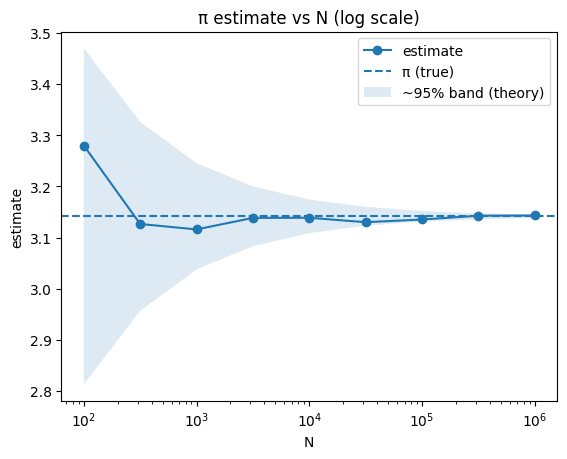

In [31]:
# Theoretical 1/sqrt(N) standard deviation band
p = np.pi / 4.0
c = 4.0 * np.sqrt(p * (1.0 - p))  # ~1.64
sigma = c / np.sqrt(Ns)

plt.figure()
plt.title("π estimate vs N (log scale)")
plt.plot(Ns, est, marker='o', label="estimate")
plt.axhline(np.pi, linestyle='--', label="π (true)")
# 95% band (approximately) around true π
plt.fill_between(Ns, np.pi - 2*sigma, np.pi + 2*sigma, alpha=0.15, label="~95% band (theory)")
plt.xscale('log')
plt.xlabel("N")
plt.ylabel("estimate")
plt.legend()
plt.show()


אנו רואים כי הגדלת מספר הדגימות $N$ גורמת להערכות $\hat{\pi}$ להיות קרובות יותר לערך האמיתי.

In [32]:
import json
from jupyterquiz import display_quiz

example = \
'''
[{
  "question": "בדוגמת מונטה–קרלו להערכת π אנו זורקים N נקודות אחידות בריבוע [-1,1]×[-1,1].<br><br>מהי הנוסחה להערכת π מתוך הניסוי?",
  "type": "many_choice",
  "answers": [
    {
      "answer": "π ≈ 4 * (מספר הנקודות בתוך המעגל / סך כל הנקודות)",
      "correct": true,
      "feedback": "נכון! שטח המעגל חלקי שטח הריבוע נותן את היחס, וכפול 4 משחזר את π"
    },
    {
      "answer": "π ≈ (מספר הנקודות מחוץ למעגל / סך כל הנקודות)",
      "correct": false,
      "feedback": "לא נכון — הנקודות שמחוץ למעגל אינן נותנות הערכה ישירה ל-π"
    },
    {
      "answer": "π ≈ (שטח הריבוע / שטח המעגל)",
      "correct": false,
      "feedback": "לא נכון — היחס הפוך: שטח המעגל חלקי שטח הריבוע קשור ל-π"
    },
    {
      "answer": "הערך תמיד שווה בדיוק ל-3.14 ללא תלות ב-N",
      "correct": false,
      "feedback": "לא נכון — ככל ש-N גדל ההערכה משתפרת, אבל היא לעולם אינה בדיוק 3.14"
    }
  ]
}]
'''
myquiz = json.loads(example)
display_quiz(myquiz)


<IPython.core.display.Javascript object>

### גרף 2: השגיאה המוחלטת $(|\hat{\pi} - \pi|)$ לעומת $(N)$

נציג גרף לוג–לוג של השגיאה מול $(N)$, ונשווה לעקומה היחסית של־ $(1/\sqrt{N})$.  

`````{admonition} גרף לוג–לוג (log-log)
:class: tip
בגרף לוג–לוג שני הצירים (האופקי והאנכי) מוצגים בסקאלה לוגריתמית.  
במקום להציג ישירות את $N$ או את גודל השגיאה, מציגים את $\log(N)$ ואת $\log(\text{error})$.

יתרונות:
- קל לזהות קשרים מסוג חזקה: אם $\text{error} \sim 1/\sqrt{N}$,  
  אז $\log(\text{error}) \sim -\tfrac{1}{2} \log(N)$, כלומר קו ישר עם שיפוע $-0.5$.
- מאפשר לראות בבירור מגמות גם כשיש טווחים גדולים מאוד של ערכים (למשל מ־$10^2$ עד $10^6$).
`````

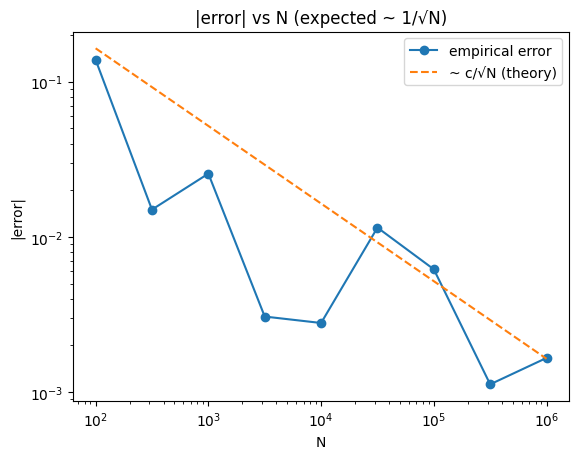

In [33]:
plt.figure()
plt.title("|error| vs N (expected ~ 1/√N)")
plt.loglog(Ns, abs_err, marker='o', label="empirical error")
plt.loglog(Ns, c/np.sqrt(Ns), linestyle='--', label="~ c/√N (theory)")
plt.xlabel("N")
plt.ylabel("|error|")
plt.legend()
plt.show()

### הסבר לגרף השגיאה בהערכת π

- **ציר X (אופקי)** – מספר הדגימות $N$, מוצג בסקאלה לוגריתמית.  
- **ציר Y (אנכי)** – גודל השגיאה המוחלטת $|\hat{\pi} - \pi|$, גם בסקאלה לוגריתמית.  

**הקו הכחול** – השגיאה שחושבה בפועל (ניסוי מונטה–קרלו).  
**הקו הכתום** – התחזית התאורטית: ירידה בקצב $1/\sqrt{N}$.  

- ככל ש־$N$ גדל, השגיאה קטנה ומתקרבת לקו התאורטי.  
- ההתנהגות מתאימה לחוק המספרים הגדולים: כדי לשפר את הדיוק פי 10 צריך בערך פי 100 יותר דגימות.  


In [34]:
import json
from jupyterquiz import display_quiz

example = \
'''
[{
  "question": "בדוגמת מונטה–קרלו להערכת π, ככל שמגדילים את N מספר הנקודות:<br><br>איך השגיאה הטיפוסית של ההערכה מתנהגת?",
  "type": "many_choice",
  "answers": [
    {
      "answer": "השגיאה קטנה בערך כמו 1/√N",
      "correct": true,
      "feedback": "נכון! זהו קצב ההתכנסות הסטנדרטי של ממוצע מקרי (חוק המספרים הגדולים וחוק השגיאות)"
    },
    {
      "answer": "השגיאה קטנה בערך כמו 1/N",
      "correct": false,
      "feedback": "לא נכון — זה היה קורה רק בשיטות דטרמיניסטיות מסוימות, לא במונטה–קרלו"
    },
    {
      "answer": "השגיאה לא תלויה ב-N, היא קבועה",
      "correct": false,
      "feedback": "לא נכון — ככל שמוסיפים עוד נקודות השגיאה יורדת"
    },
    {
      "answer": "השגיאה דווקא גדלה ככל ש-N גדל",
      "correct": false,
      "feedback": "לא נכון — היא קטנה, אחרת מונטה–קרלו לא היה עובד!"
    }
  ]
}]
'''
myquiz = json.loads(example)
display_quiz(myquiz)


<IPython.core.display.Javascript object>

### סיכום
* ההערכה $(\hat{\pi} = 4 \cdot \text{(ratio of points in circle)})$ מתכנסת לערך האמיתי ככל ש־$N$ גדל.
* השגיאה הטיפוסית קטנה בערך כמו $1/\sqrt{N}$: כדי לחצות את השגיאה בחצי צריך בערך פי 4 יותר דגימות.
* שימוש ב־`default_rng` עם `seed` קבוע מאפשר **שחזור** של אותן תוצאות בכל הפעלה.
